In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
# https://stackoverflow.com/questions/47648133/mape-calculation-in-python
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

# https://stackoverflow.com/questions/49604269/run-all-regressors-against-the-data-in-scikit
def evaluate_model(model, train, test, model_name):
    
#     exog_cols=train.columns.tolist()
#     exog_cols.remove('amount_p$_sum')
#     exog_cols.remove('reference_date')
    # fit the model
    model=model.fit()
    
    if model_name!='Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)':
    # predict the values using training data
        train_pred = model.predict(start=train.index[0], end=train.index[-1])
    else:
        train_pred = model.predict(start=train.index[0], exog=train[exog_cols], end=train.index[-1])

    
    # evaluate using training data
    train_mape = mape(train['amount_p$_sum'], train_pred)
    
    if model_name!='Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)':
    # predict the values using testing data
        test_pred = model.predict(start=test.index[0], end=test.index[-1])
    else:
        test_pred = model.predict(start=test.index[0], exog=test[exog_cols], end=test.index[-1])
        
    
    exog=test[exog_cols]
    # evaluate using testing data
    test_mape = mape(test['amount_p$_sum'], test_pred)
    
    plot_model(train,test,train_pred,test_pred,model_name)
    
    print("Mean Absolute Percentage Error: {:.2f}\n".format(train_mape))
    print("Mean Absolute Percentage Error: {:.2f}\n".format(test_mape))
            
    return train_mape, test_mape

def plot_model(train,test,train_pred,test_pred,model_name):
    plt.figure(figsize=(12, 8))
    plt.plot(train.index, train['amount_p$_sum'], label='Training Data', color='blue')
    plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data', color='green')

    plt.plot(train.index, train_pred, label=str(model_name)+' Train', color='red')
    plt.plot(test.index, test_pred, label=str(model_name)+' Test', color='orange')
    plt.title(str(model_name)+' - Train and Test Data vs. Predictions')
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.legend()
    # Show the plot
    plt.grid(True)
    plt.show()
    

In [3]:
invoice_df=pd.read_excel("InvoiceData_concate_cleaned_grouped_flu_stock_weekly.xlsx")

In [4]:
invoice_df.head()

,reference_date,customer_name_top_Customer 1,customer_name_top_Customer 2,customer_name_top_Customer 3,customer_name_top_Customer 4,customer_name_top_Customer 5,customer_name_top_Customer 6,customer_name_top_Customer 7,customer_name_top_Customer 8,day_Friday,...,Volume_HELX,Volume_IHI,Volume_XLV,Close_HELX,Close_IHI,Close_XLV,Volume_DHR,Volume_TMO,Close_DHR,Close_TMO
0,2020-12-28,1,0,4,0,2,2,1,0,10,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-01-04,269,162,651,135,155,143,254,5,256,...,15.166667,4.844308,4.924573,5.268076,5.121616,5.101993,5.281879,4.839443,5.248175,5.187106
2,2021-01-11,308,144,630,116,52,102,236,14,310,...,16.000000,19.492188,2.868756,5.559773,5.171015,5.180700,3.659546,3.800261,5.367111,5.328049
3,2021-01-18,256,226,579,111,37,134,206,27,282,...,21.833333,7.587054,2.632809,5.725794,5.194018,5.213370,3.757839,3.764727,5.290732,5.411640
4,2021-01-25,289,299,644,172,65,151,190,11,208,...,26.722222,5.302455,3.767980,5.469415,5.140734,5.149713,5.278497,4.155422,5.199749,5.331101


In [5]:
normal_df = invoice_df.reset_index()
normal_df.head()

,index,reference_date,customer_name_top_Customer 1,customer_name_top_Customer 2,customer_name_top_Customer 3,customer_name_top_Customer 4,customer_name_top_Customer 5,customer_name_top_Customer 6,customer_name_top_Customer 7,customer_name_top_Customer 8,...,Volume_HELX,Volume_IHI,Volume_XLV,Close_HELX,Close_IHI,Close_XLV,Volume_DHR,Volume_TMO,Close_DHR,Close_TMO
0,0,2020-12-28,1,0,4,0,2,2,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2021-01-04,269,162,651,135,155,143,254,5,...,15.166667,4.844308,4.924573,5.268076,5.121616,5.101993,5.281879,4.839443,5.248175,5.187106
2,2,2021-01-11,308,144,630,116,52,102,236,14,...,16.000000,19.492188,2.868756,5.559773,5.171015,5.180700,3.659546,3.800261,5.367111,5.328049
3,3,2021-01-18,256,226,579,111,37,134,206,27,...,21.833333,7.587054,2.632809,5.725794,5.194018,5.213370,3.757839,3.764727,5.290732,5.411640
4,4,2021-01-25,289,299,644,172,65,151,190,11,...,26.722222,5.302455,3.767980,5.469415,5.140734,5.149713,5.278497,4.155422,5.199749,5.331101


## Weekly

In [6]:
# normal_df['reference_date'] = pd.to_datetime(normal_df['reference_date'])
# normal_df.set_index('reference_date', inplace=True)

# # Fill missing dates if any
# normal_df = normal_df.resample('D').asfreq()

# # Fill missing values with appropriate method
# normal_df['amount_p$_sum'].fillna(method='ffill', inplace=True)

# Split data into training and testing sets
# train_size = int(len(normal_df) * 0.8)
train_size=18
train, test = normal_df.iloc[:-train_size], normal_df.iloc[-train_size:]

## Daily

In [7]:
# normal_df['reference_date'] = pd.to_datetime(normal_df['reference_date'])
# normal_df.set_index('reference_date', inplace=True)

# # Fill missing dates if any
# normal_df = normal_df.resample('D').asfreq()

# # Fill missing values with appropriate method
# normal_df['amount_p$_sum'].fillna(method='ffill', inplace=True)

# # Split data into training and testing sets
# # train_size = int(len(normal_df) * 0.8)
# train_size=90
# train, test = normal_df.iloc[:-train_size], normal_df.iloc[-train_size:]

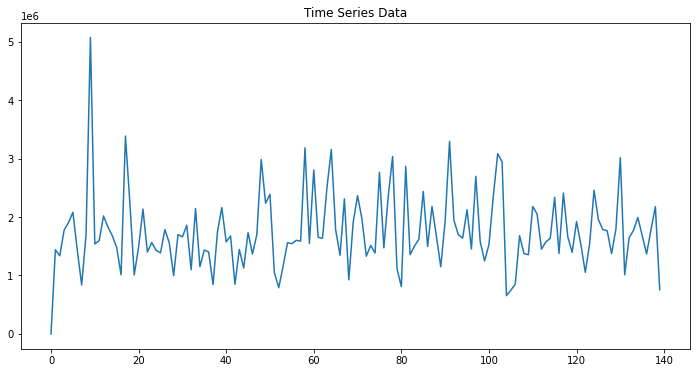

In [8]:
# Plot the time series data
normal_df['amount_p$_sum'].plot(figsize=(12, 6), label='Original Data')
plt.title('Time Series Data')
plt.show()

In [9]:
exog_cols=invoice_df.columns.tolist()
exog_cols.remove('amount_p$_sum')
exog_cols.remove('reference_date')
# display(exog_cols)

In [10]:
base_models = [
    ('Simple Exponential Smoothing (SES)',SimpleExpSmoothing(train['amount_p$_sum'])),
    ("Holt/'s Simple Exponential Smoothing (HWES)",Holt(train['amount_p$_sum'])),
    ('Auto Regression (AR)',AutoReg(train['amount_p$_sum'],lags=1)),
    ('Moving Average (MA)',ARIMA(train['amount_p$_sum'], order=(0, 0, 1))),
    ('Autoregressive Moving Average (ARMA)',ARIMA(train['amount_p$_sum'], order=(2, 0, 1))),
    ('Autoregressive Integrated Moving Average (ARIMA)',ARIMA(train['amount_p$_sum'], order=(1, 1, 1))),
    ('Seasonal Autoregressive Integrated Moving-Average (SARIMA)',SARIMAX(train['amount_p$_sum'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))),
    ('Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)',SARIMAX(train['amount_p$_sum'], exog=train[exog_cols], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)))
    
    
]


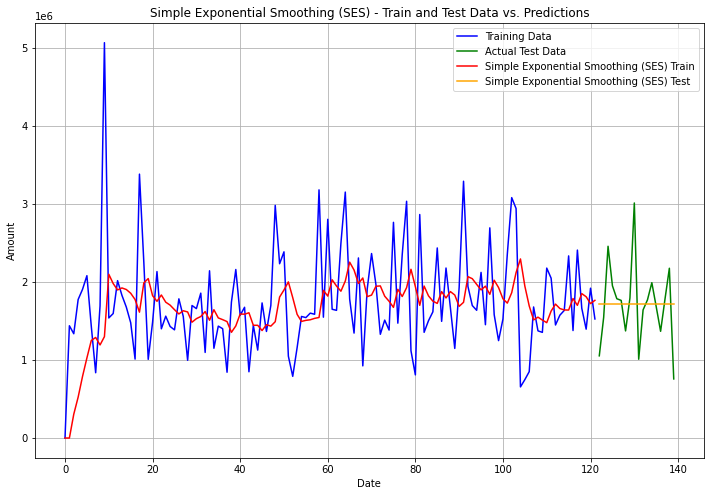

Mean Absolute Percentage Error: 34.77

Mean Absolute Percentage Error: 25.85



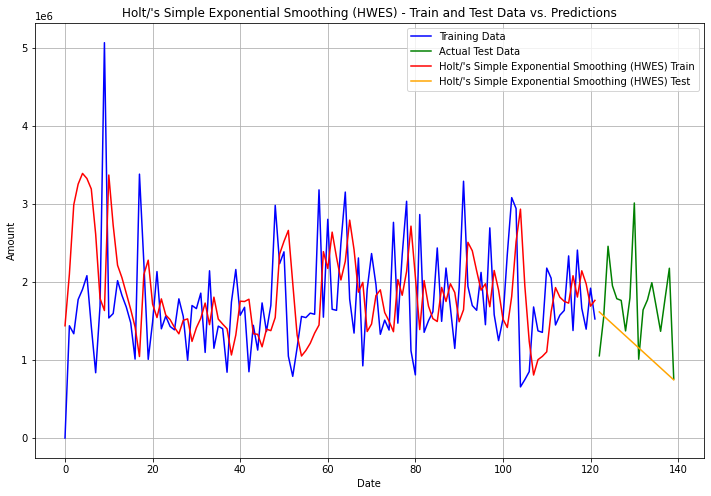

Mean Absolute Percentage Error: 1308.92

Mean Absolute Percentage Error: 32.74



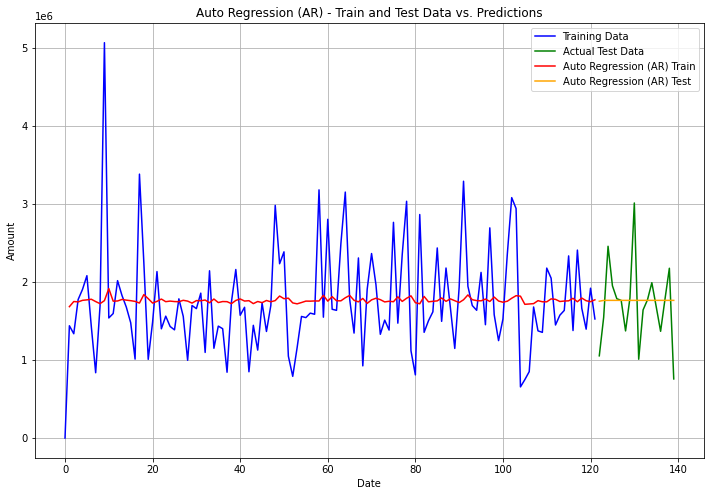

Mean Absolute Percentage Error: nan

Mean Absolute Percentage Error: 26.22



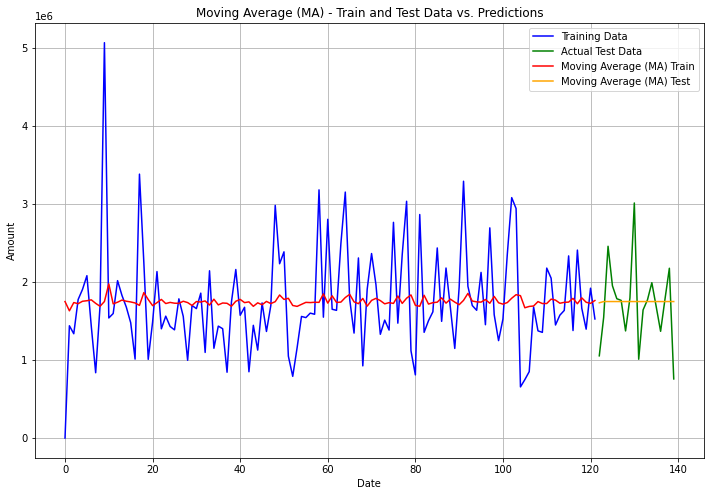

Mean Absolute Percentage Error: 1568.15

Mean Absolute Percentage Error: 26.06



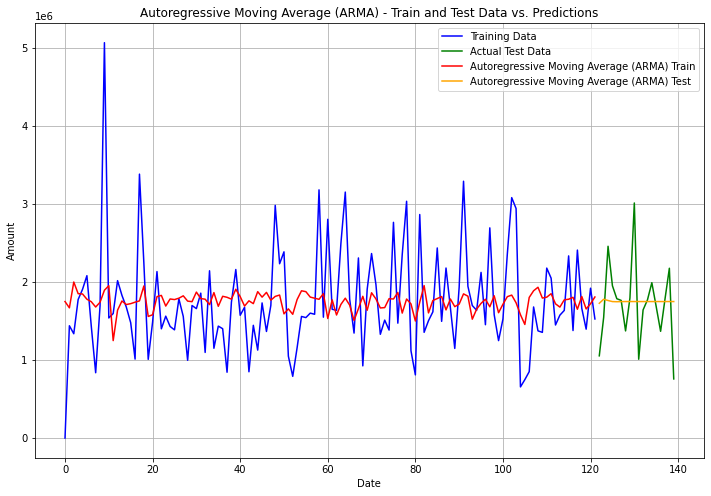

Mean Absolute Percentage Error: 1567.97

Mean Absolute Percentage Error: 26.12



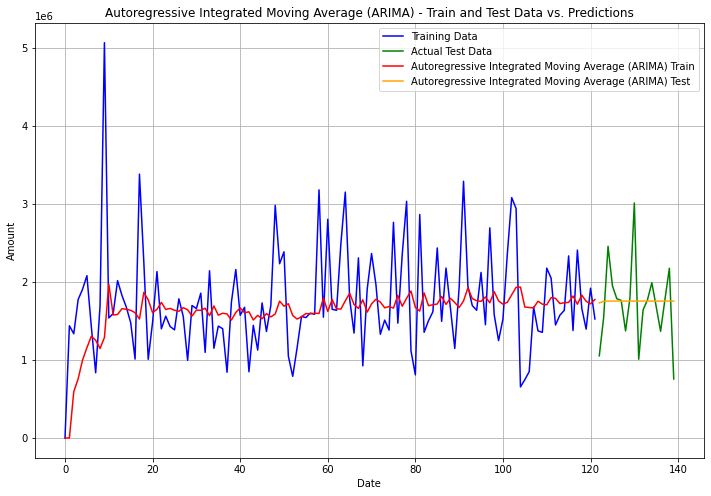

Mean Absolute Percentage Error: 31.32

Mean Absolute Percentage Error: 26.07



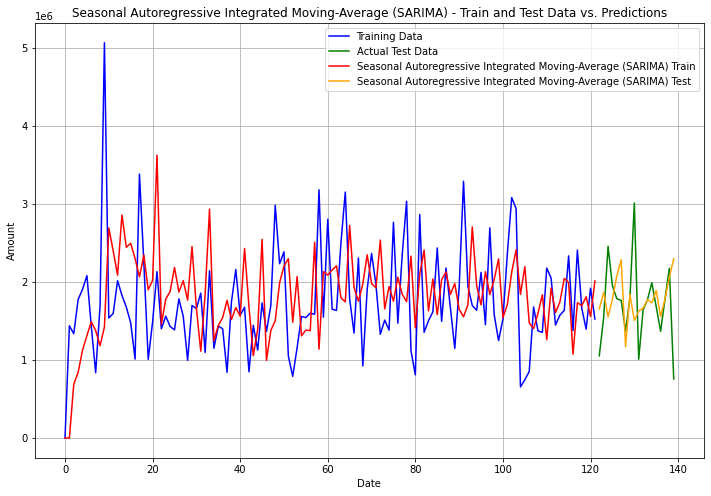

Mean Absolute Percentage Error: 41.27

Mean Absolute Percentage Error: 30.41



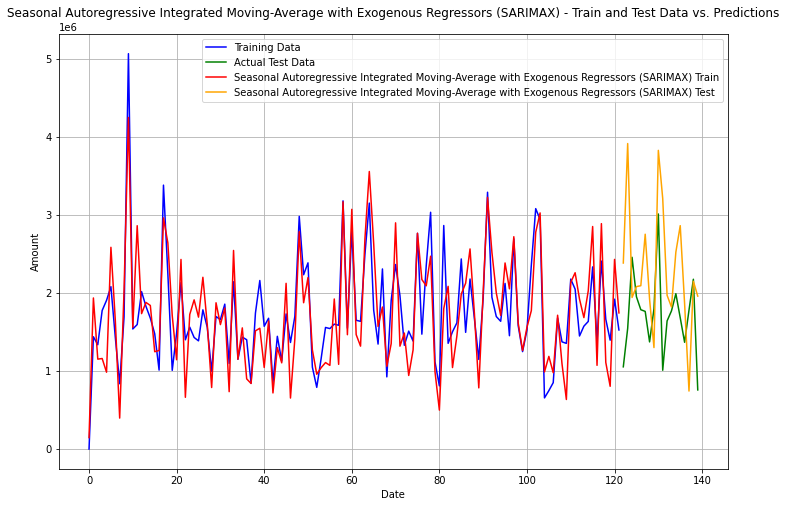

Mean Absolute Percentage Error: 149.47

Mean Absolute Percentage Error: 59.31



In [11]:
train_mape_l, test_mape_l, model_name_l =[], [], []

for name, model_n in base_models:
#     start_time = time.time()
    train_mape, test_mape=\
    evaluate_model(model_n, train, test,name)
    train_mape_l.append(train_mape)
    test_mape_l.append(test_mape)
    model_name_l.append(name)
#     end_time = time.time()
#     print("Computation Time: {}".format(end_time - start_time))
#     print("----------------------------------\n")
    

In [12]:
modelval_data = {
    "Model Name": model_name_l,
    "Train MAPE": train_mape_l,
    "Test MAPE": test_mape_l
}
model_metric_df = pd.DataFrame(modelval_data)

In [13]:
model_metric_df[['Model Name','Train MAPE','Test MAPE']].style.background_gradient(cmap='Reds')

,Model Name,Train MAPE,Test MAPE
0,Simple Exponential Smoothing (SES),34.765115,25.845266
1,Holt/'s Simple Exponential Smoothing (HWES),1308.919911,32.737635
2,Auto Regression (AR),nan,26.220715
3,Moving Average (MA),1568.147834,26.063280
4,Autoregressive Moving Average (ARMA),1567.969828,26.117957
5,Autoregressive Integrated Moving Average (ARIMA),31.315965,26.068701
6,Seasonal Autoregressive Integrated Moving-Average (SARIMA),41.270338,30.406304
7,Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX),149.467293,59.308038


In [14]:
model_metric_df['diff'] = (model_metric_df['Train MAPE'] - model_metric_df['Test MAPE']).abs()

In [15]:
model_metric_df[['Model Name','Train MAPE','Test MAPE','diff']]\
                .sort_values(['diff','Test MAPE','Train MAPE'],ascending=True).style.background_gradient(cmap='Reds')

,Model Name,Train MAPE,Test MAPE,diff
5,Autoregressive Integrated Moving Average (ARIMA),31.315965,26.068701,5.247264
0,Simple Exponential Smoothing (SES),34.765115,25.845266,8.919849
6,Seasonal Autoregressive Integrated Moving-Average (SARIMA),41.270338,30.406304,10.864034
7,Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX),149.467293,59.308038,90.159255
1,Holt/'s Simple Exponential Smoothing (HWES),1308.919911,32.737635,1276.182276
4,Autoregressive Moving Average (ARMA),1567.969828,26.117957,1541.851871
3,Moving Average (MA),1568.147834,26.063280,1542.084554
2,Auto Regression (AR),nan,26.220715,nan


## Whole Code

### Simple Exponential Smoothing (SES)

In [2]:
# Simple Exponential Smoothing
model_ses = SimpleExpSmoothing(train['amount_p$_sum']).fit()

pred_ses_train = model_ses.predict(start=train.index[0], end=train.index[-1])
pred_ses_test = model_ses.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')


plt.plot(train.index, pred_ses_train, label='Simple Exponential Smoothing Train')
plt.plot(test.index, pred_ses_test, label='Simple Exponential Smoothing Test')
plt.title('Simple Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

train_mape_ses = mape(train['amount_p$_sum'], pred_ses_train)
test_mape_ses = mape(test['amount_p$_sum'], pred_ses_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape_ses))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape_ses))


NameError: name 'train' is not defined

### Holt's Simple Exponential Smoothing (HWES)

In [ ]:
# Holt's Exponential Smoothing
model_holt = Holt(train['amount_p$_sum']).fit()

pred_holt_train = model_holt.predict(start=train.index[0], end=train.index[-1])
pred_holt_test = model_holt.predict(start=test.index[0], end=test.index[-1])


plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')

plt.plot(train.index, pred_holt_train, label='Holt\'s Exponential Smoothing Train')
plt.plot(test.index, pred_holt_test, label='Holt\'s Exponential Smoothing Test')

plt.title('Holt\'s Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


train_mape_hwes = mape(train['amount_p$_sum'], pred_holt_train)
test_mape_hwes = mape(test['amount_p$_sum'], pred_holt_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape_hwes))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape_hwes))

### Autoregression (AR)

In [ ]:
# Autoregression
model_ar = AutoReg(train['amount_p$_sum'], lags=1).fit()

pred_ar_train = model_ar.predict(start=train.index[0], end=train.index[-1])
pred_ar_test = model_ar.predict(start=test.index[0], end=test.index[-1])


plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')

plt.plot(train.index, pred_ar_train, label='AutoRegression Train')
plt.plot(test.index, pred_ar_test, label='AutoRegression Test')

plt.title('Autoregression')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


train_mape_ar = mape(train['amount_p$_sum'], pred_ar_train)
test_mape_ar = mape(test['amount_p$_sum'], pred_ar_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape_ar))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape_ar))

### Moving Average (MA)

In [ ]:
# Moving Average
model_ma = ARIMA(train['amount_p$_sum'], order=(0, 0, 1)).fit()

pred_ma_train = model_ma.predict(start=train.index[0], end=train.index[-1])
pred_ma_test = model_ma.predict(start=test.index[0], end=test.index[-1])


plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')

plt.plot(train.index, pred_ma_train, label='Moving Average Train')
plt.plot(test.index, pred_ma_test, label='Moving Average Test')

plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


train_mape_ma = mape(train['amount_p$_sum'], pred_ma_train)
test_mape_ma = mape(test['amount_p$_sum'], pred_ma_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape_ma))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape_ma))

### Autoregressive Moving Average (ARMA)

In [ ]:
# Autoregressive Moving Average (ARMA)
model_arma = ARIMA(train['amount_p$_sum'], order=(2, 0, 1)).fit()

pred_arma_train = model_arma.predict(start=train.index[0], end=train.index[-1])
pred_arma_test = model_arma.predict(start=test.index[0], end=test.index[-1])


plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')

plt.plot(train.index, pred_arma_train, label='Autoregressive Moving Average Train')
plt.plot(test.index, pred_arma_test, label='Autoregressive Moving Averagen Test')

plt.title('Autoregressive Moving Average')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


train_mape_arma = mape(train['amount_p$_sum'], pred_arma_train)
test_mape_arma = mape(test['amount_p$_sum'], pred_arma_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape_arma))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_map_armae))

### Autoregressive Integrated Moving Average (ARIMA)

In [ ]:
# Autoregressive Integrated Moving Average (ARIMA)
model_arima = ARIMA(train['amount_p$_sum'], order=(1, 1, 1)).fit()

pred_arima_train = model_arima.predict(start=train.index[0], end=train.index[-1])
pred_arima_test = model_arima.predict(start=test.index[0], end=test.index[-1])


plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')

plt.plot(train.index, pred_arima_train, label='Autoregressive Integrated Moving Average (ARIMA) Train')
plt.plot(test.index, pred_arima_test, label='Autoregressive Integrated Moving Average (ARIMA) Test')

plt.title('Autoregressive Integrated Moving Average')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


train_mape_arima = mape(train['amount_p$_sum'], pred_arima_train)
test_mape_arima = mape(test['amount_p$_sum'], pred_arima_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape_arima))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape_arima))

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [ ]:
# Seasonal Decomposition of Time Series (STL) with ARIMA
model_sarima = SARIMAX(train['amount_p$_sum'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)

pred_sarima_train = model_sarima.predict(start=train.index[0], end=train.index[-1])
pred_sarima_test = model_sarima.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')


plt.plot(train.index, pred_sarima_train, label='SARIMA Train')
plt.plot(test.index, pred_sarima_test, label='SARIMA Test')

plt.title('SARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

train_mape_sarima = mape(train['amount_p$_sum'], pred_sarima_train)
test_mape_sarima = mape(test['amount_p$_sum'], pred_sarima_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape_sarima))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape_sarima))

In [ ]:
exog_cols=invoice_df.columns.tolist()
exog_cols.remove('amount_p$_sum')
exog_cols.remove('reference_date')
display(exog_cols)

In [ ]:
train[exog_cols]

### Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors SARIMAX

In [ ]:
# Seasonal Decomposition of Time Series (STL) with ARIMA
model_sarimax = SARIMAX(train['amount_p$_sum'], exog=train[exog_cols], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)

pred_sarimax_train = model_sarimax.predict(start=train.index[0], exog=train[exog_cols],end=train.index[-1])
pred_sarimax_test = model_sarimax.predict(start=test.index[0], exog=test[exog_cols],end=test.index[-1])

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')


plt.plot(train.index, pred_sarimax_train, label='SARIMA Train')
plt.plot(test.index, pred_sarimax_test, label='SARIMA Test')

plt.title('SARIMAX Forecasting')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

train_mape_sarimax = mape(train['amount_p$_sum'], pred_sarimax_train)
test_mape_sarimax = mape(test['amount_p$_sum'], pred_sarimax_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape_sarimax))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape_sarimax))

### Vector Autoregression Moving-Average (VARMA)


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX

# Seasonal Decomposition of Time Series (STL) with ARIMA
model_varima = VARMAX(train['amount_p$_sum']).fit(disp=False)

pred_varima_train = model_varima.predict(start=train.index[0], end=train.index[-1])
pred_varima_test = model_varima.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')

plt.plot(train.index, pred_varima_train, label='VARIMA Train')
plt.plot(test.index, pred_varima_test, label='VARIMA Test')

plt.title('VARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

train_mape = mape(train['amount_p$_sum'], pred_varima_train)
test_mape = mape(test['amount_p$_sum'], pred_varima_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape))


In [ ]:
# Prophet
train_prophet = train.reset_index().rename(columns={'reference_date': 'ds', 'amount_p$_sum': 'y'})
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Create a future DataFrame with only the dates from the test set
future_train = model_prophet.make_future_dataframe(periods=len(train))
future_train = future_train[future_train['ds'].isin(train.index)]

# Predict on the future DataFrame
pred_prophet_train = model_prophet.predict(future_train)['yhat']


# Create a future DataFrame with only the dates from the test set
future_test = model_prophet.make_future_dataframe(periods=len(test))
future_test = future_test[future_test['ds'].isin(test.index)]

# Predict on the future DataFrame
pred_prophet_test = model_prophet.predict(future_test)['yhat']


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')

plt.plot(train.index, pred_prophet_train, label='Prophet Train')
plt.plot(test.index, pred_prophet_test, label='Prophet Test')

plt.title('Prophet Forecasting')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

train_mape = mape(train['amount_p$_sum'], pred_prophet_train)
test_mape = mape(test['amount_p$_sum'], pred_prophet_test)

print("Mean Absolute Percentage Error(Train): {:.2f}".format(train_mape))
print("Mean Absolute Percentage Error(Test): {:.2f}".format(test_mape))

In [ ]:
# Linear Regression
X_train = np.array(range(len(train))).reshape(-1, 1)
y_train = train['amount_p$_sum'].values
model_lr = LinearRegression().fit(X_train, y_train)

X_test = np.array(range(len(train), len(normal_df))).reshape(-1, 1)
pred_lr = model_lr.predict(X_test)

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['amount_p$_sum'], label='Training Data')
plt.plot(test.index, test['amount_p$_sum'], label='Actual Test Data')
plt.plot(test.index, pred_lr, label='Linear Regression')
plt.title('Linear Regression Forecasting')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()
